## Library import

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

! pip install transformers
! pip install --upgrade gensim
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

Mounted at /content/drive
     |████████████████████████████████| 4.0 MB 11.2 MB/s 
     |████████████████████████████████| 895 kB 50.2 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 24.1 MB 62.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Language processing
import string
import nltk
import re

# System
import sys
path_smt = '/content/drive/MyDrive/dis/'
sys.path.append(path_smt)
import time

# Data preprocessing
from preprocessing import * 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler

# Statistical tools
import scipy.stats as stat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Plotting
import matplotlib.pyplot as plt

# Word2vec
import gensim
import gensim.downloader
from gensim.models import Word2Vec
google_news_vectors = gensim.downloader.load('word2vec-google-news-300')

# Bert
import torch
from transformers import BertModel

# Glove
embeddings_dict = {}
with open(path_smt + "glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
        
# Calibration
from sklearn.isotonic import IsotonicRegression

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Data import

In [ ]:
def import_data(sts=False, subsample = False):
    if sts:
#         STS has the train and test files separately
        dt_train = pd.read_csv(path_smt+"sts-train.csv", sep='\t', 
                          header = None, encoding='utf-8',
                names = ["drop1", "drop2", "drop3", "drop4", "sim", "sent1", "sent2"])
        dt_train.loc[:, ("split")] = "TRAIN"
        dt_test = pd.read_csv(path_smt+"sts-test.csv", sep='\t', 
                          header = None, encoding='utf-8', engine="python", quoting = 3,
                names = ["drop1", "drop2", "drop3", "drop4", "sim", "sent1", "sent2", "bad1", "bad2"])
        dt_test.loc[:, ("split")] = "TEST"
        dt_drop = pd.concat([dt_train, dt_test])
        dt_full = dt_drop[["sim", "sent1", "sent2", "split"]].reset_index()
    else:
        dt_raw = pd.read_csv(path_smt+"SICK.txt", sep='\t', encoding='utf-8')
        dt_names = dt_raw[["sentence_A", "sentence_B", "relatedness_score", "SemEval_set"]]
        dt_full = dt_names.rename(columns = {'sentence_A':'sent1', 'sentence_B':'sent2', 
                                    "relatedness_score":"sim", "SemEval_set":"split"})
    dt = dt_full[(dt_full.sent1.str.len() < 220) & (dt_full.sent2.str.len() < 220)].reset_index()
    dt.loc[:, ("sim01")] = (dt["sim"] - min(dt["sim"]))/(max(dt["sim"]) - min(dt["sim"]))
    # Subsample for BERT
    if subsample:
        dt = dt.sample(frac = 0.2, random_state = 1, ignore_index=True)
    dt_long = pd.concat([dt[["sent1"]].rename(columns = {"sent1":"sent"}), 
                     dt[["sent2"]].rename(columns={"sent2":"sent"})], ignore_index=True)
    return dt, dt_long

sick, sick_long = import_data(sts=False)
sick_bert, sick_bert_long = import_data(sts=False, subsample = True)
sts, sts_long = import_data(sts=True)
sts_bert, sts_bert_long = import_data(sts=True, subsample=True)

### Plot of similarity scores distribution

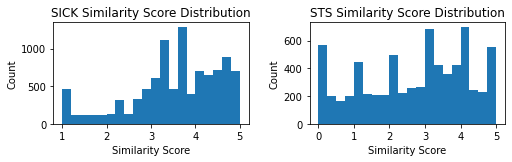

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,2))
fig.tight_layout(w_pad = 3)
ax[0].hist(sick['sim'], bins = 20)
ax[0].set_title('SICK Similarity Score Distribution')
ax[0].set_xlabel("Similarity Score")
ax[0].set_ylabel("Count")

ax[1].hist(sts['sim'], bins = 20)
ax[1].set_title('STS Similarity Score Distribution')
ax[1].set_xlabel("Similarity Score")
ax[1].set_ylabel("Count")
# plt.savefig("dist_similarity.pdf", bbox_inches='tight')

## Adding out-of-vocabulary words to Glove and Word2Vec

In [ ]:
# Checking if lemmatised versions are in vocabulary
wnl = WordNetLemmatizer()
# All keys in embeddings dictionary
google_lst = google_news_vectors.index_to_key
glove_keys = embeddings_dict.keys()

In [ ]:

def lemmatise(dt_long):
    preprocess("sent", dt_long)
    # All words appearing in dataset
    all_words = set(' '.join(dt_long['sent_punct']).split())   
    # Words not present in word2vec dictionary
    add_google = all_words.difference(google_lst)
    # Words not present in GloVe dictionary
    add_glove = all_words.difference(glove_keys)
    # If lemmatised versions in dictionary, change the words to their lemmatised version
    new_long = add_words(add_google, dt_long, google_news_vectors)
    newer_long = add_words(add_glove, new_long, embeddings_dict)
    return newer_long

def add_words(absent, dt_long, diction):
    replace_long = dt_long
    for wrd in absent:
        # Lemmatise
        lem = wnl.lemmatize(wrd)
        if lem != wrd:
            if lem in diction:
              # If lemmatised version in dictionary, replace the word in the dataset
                replace_long = replace_long.replace({wrd:lem}, regex=True)
    return replace_long
                
sick_long = lemmatise(sick_long)
sts_long = lemmatise(sts_long)

In [ ]:
# If lemmatised not in vocabulary then create a random vector
all_words_sick = set(' '.join(sick_long['sent_punct']).split())   
all_words_sts = set(' '.join(sts_long['sent_punct']).split()) 
# All words in both datasets
all_words = all_words_sick.union(all_words_sts)

# Add all unknown words from both datasets
add_google = all_words.difference(google_lst)
for wrd in add_google:
    google_news_vectors[wrd] = np.random.normal(size = 300)
add_glove = all_words.difference(glove_keys)    
for wrd in add_glove:
    embeddings_dict[wrd] = np.random.normal(size = 50)

## Vector average

In [ ]:
# Compute vector average for two sentences
def comp_aver(var,  diction, j, base_emb):
  # Specify dimension of the end vector based on the embedding used
    if base_emb == "glove":
        len_emb = 50
    elif base_emb == "bert":
        len_emb = 768
    else:
        len_emb = 300

# Vector for all word vectors
    word_vectors = np.zeros((len_emb, len(var[j])))
    for i in range(len(var[j])):
        wrd = var[j][i]
#         Obtain word vector
        word_vectors[:, i] = diction[wrd]
#             Return the average of all word vectors
    return(np.sum(word_vectors, axis = 1)/len(var[j]))

# Compute vector average for whole dataframe
def add_stats(dt, dt1, dt2, emb, dicti):
    sims = np.zeros(len(dt1))
    for jj in range(len(dt1)):
        avg_vec1 = comp_aver(dt1, base_emb = emb, diction = dicti, j = jj)
        avg_vec2 = comp_aver(dt2, base_emb = emb, diction = dicti, j = jj)

#         Compute cosine distance
        sims[jj] = 1 - spatial.distance.cosine(avg_vec1, avg_vec2)

    # Adding the calculated similarity to the dataframe
    dt.loc[:, (emb + "_sim")] = sims

## Preprocessing: Bert

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
preprocess("sent", sick_bert_long)
preprocess("sent", sts_bert_long)

In [ ]:
def create_bert_dict(dt_long, dt):
#     All word ids and bert tokenised text
    tensor_token, normal_tokens, _ = bert_preprocess(dt_long.sent_punct)
    
    with torch.no_grad():
        outputs_sim = model(tensor_token)
        sim_vecs = outputs_sim[2][-2]

# Reshape the values to create a dictionary of bert keys and values
    sim_vecs_list = torch.reshape(sim_vecs, (sim_vecs.size()[0]*sim_vecs.size()[1], 768))
    
    un = unpad(normal_tokens)
#     Save bert preprocessed data in the final dataframe
    dt.loc[:,("bert_tokens1")] = un[0:int((len(normal_tokens)/2))]
    dt.loc[:,("bert_tokens2")] = un[int((len(normal_tokens)/2)):]
    return dict(zip(flatten(normal_tokens), sim_vecs_list))

# Predictions

In [ ]:
def get_predictions(dt, dt_long, dt_bert, dt_bert_long, bert_dict):
    # Add preprocessed data for Word2Vec and Glove to the main dataframe
    dt.loc[:,("sent_punct1")] = dt_long.sent_punct[0:int((len(dt_long)/2))]
    dt.loc[:,("sent_punct2")] = dt_long[int((len(dt_long)/2)):].reset_index().sent_punct
    
    # Tokenising as the final preprocessing stage for Word2Vec and Glove
    tokens1 = dt.apply(lambda row: nltk.word_tokenize(row['sent_punct1']), axis=1)
    tokens2 = dt.apply(lambda row: nltk.word_tokenize(row['sent_punct2']), axis=1)
    
#     Adding vector average
    add_stats(dt_bert, dt_bert.bert_tokens1, dt_bert.bert_tokens2, emb = "bert", dicti = bert_dict)
    # print("Time before aver for Glove and Google:", time.time())
    add_stats(dt, tokens1, tokens2, emb = "google", dicti = google_news_vectors)
    add_stats(dt, tokens1, tokens2, emb = "glove", dicti = embeddings_dict)
    # print("Time after aver for Glove and Google:", time.time())
    
#     WMD
    sims_bert = np.zeros(len(dt_bert))
    sims_glove = np.zeros(len(dt))
    sims_google = np.zeros(len(dt))
    for i in range(len(dt_bert)):
        sims_bert[i] = wmdist(bert_dict, dt_bert.bert_tokens1[i], dt_bert.bert_tokens2[i])
    # print("Time before WMD for Glove and Google:", time.time())
    for i in range(len(dt)):
        sims_glove[i] = wmdist(embeddings_dict, tokens1[i], tokens2[i])
        sims_google[i] = wmdist(google_news_vectors, tokens1[i], tokens2[i])
    # print("Time after WMD for Glove and Google:", time.time())
    
    # Adding the inverted WMD distance to dataframe
    dt["wmd_google"] = 1/(1+sims_google)
    dt["wmd_glove"] = 1/(1+sims_glove)
    dt_bert["wmd_bert"] = 1/(1+sims_bert)

In [ ]:
# SICK Bert dictionary
bert_dict_sick = create_bert_dict(sick_bert_long, sick_bert)

In [ ]:
get_predictions(sick, sick_long, sick_bert, sick_bert_long, bert_dict_sick)

Time before aver for Glove and Google: 1650718494.730287
Time after aver for Glove and Google: 1650718497.8111947
Time before WMD for Glove and Google: 1650718501.899934
Time after WMD for Glove and Google: 1650718533.1034555


Vector average takes 3 seconds and WMD takes 30 seconds.

In [ ]:
 # STS Bert dictionary
bert_dict_sts = create_bert_dict(sts_bert_long, sts_bert)

In [ ]:
get_predictions(sts, sts_long, sts_bert, sts_bert_long, bert_dict_sts)

Time before aver for Glove and Google: 1650718798.0059423
Time after aver for Glove and Google: 1650718800.4984927
Time before WMD for Glove and Google: 1650718806.5662177
Time after WMD for Glove and Google: 1650718845.585518


Vector average takes 2 seconds and WMD takes 40 seconds.

## Test train split

In [ ]:
def test_train(dt, dt_bert):
  dt_test = dt[dt["split"] == "TEST"]
  dt_train = dt[dt["split"] == "TRAIN"]
  dt_bert_test = dt_bert[dt_bert["split"] == "TEST"]
  dt_bert_train = dt_bert[dt_bert["split"] == "TRAIN"]
  return (dt_train, dt_bert_train, dt_test, dt_bert_test)

sick_train, sick_bert_train, sick_test, sick_bert_test = test_train(sick, sick_bert)
sts_train, sts_bert_train, sts_test, sts_bert_test = test_train(sts, sts_bert)

## SICK evaluation

In [ ]:
print("Correlation for SICK average Bert:", stat.pearsonr(sick_bert_test["bert_sim"],
                                                          sick_bert_test["sim"])[0])
print("Correlation for SICK average Word2vec:", stat.pearsonr(sick_test["google_sim"], 
                                                              sick_test["sim"])[0])
print("Correlation for SICK average Glove:", stat.pearsonr(sick_test["glove_sim"],
                                                           sick_test["sim"])[0])
print("Correlation for SICK wmd Bert:", stat.pearsonr(sick_bert_test["wmd_bert"], 
                                                      sick_bert_test["sim"])[0])
print("Correlation for SICK wmd Word2vec:", stat.pearsonr(sick_test["wmd_google"], sick_test["sim"])[0])
print("Correlation for SICK wmd Glove:", stat.pearsonr(sick_test["wmd_glove"], sick_test["sim"])[0])

Correlation for SICK average Bert: 0.42418433364657965
Correlation for SICK average Word2vec: 0.710306929047443
Correlation for SICK average Glove: 0.6463377476772563
Correlation for SICK wmd Bert: 0.5262276074294747
Correlation for SICK wmd Word2vec: 0.6497038895144407
Correlation for SICK wmd Glove: 0.6403431754150863


In [ ]:
# Similar sentences
sick_sim = sick_test[sick_test.sim > 3]
# Dissimilar sentences
sick_not = sick_test[sick_test.sim <= 3]

In [ ]:
print("Correlation for similar sentences on SICK",
      stat.pearsonr(sick_sim["google_sim"], sick_sim["sim"])[0])
print("Correlation for dissimilar sentences on SICK",
      stat.pearsonr(sick_not["google_sim"], sick_not["sim"])[0])

0.3674465270020075
0.7329032626292836


Calibration does not help with balancing the quality of the predictions for similar and dissimilar sentences.

In [ ]:
print(stat.pearsonr(sick_sim["iso_google_aver"], sick_sim["sim"])[0])
print(stat.pearsonr(sick_not["iso_google_aver"], sick_not["sim"])[0])

0.37309330789255146
0.7545822462631597


## STS evaluation

In [ ]:
print("Correlation for STS average Bert:", stat.pearsonr(sts_bert_test["bert_sim"], sts_bert_test["sim"])[0])
print("Correlation for STS average Word2vec:", stat.pearsonr(sts_test["google_sim"], sts_test["sim"])[0])
print("Correlation for STS average Glove:", stat.pearsonr(sts_test["glove_sim"], sts_test["sim"])[0])
print("Correlation for STS wmd Bert:", stat.pearsonr(sts_bert_test["wmd_bert"], sts_bert_test["sim"])[0])
print("Correlation for STS wmd Word2vec:", stat.pearsonr(sts_test["wmd_google"], sts_test["sim"])[0])
print("Correlation for STS wmd Glove:", stat.pearsonr(sts_test["wmd_glove"], sts_test["sim"])[0])

Correlation for STS average Bert: 0.3636212080817468
Correlation for STS average Word2vec: 0.5580742174920632
Correlation for STS average Glove: 0.5464378027311095
Correlation for STS wmd Bert: 0.38933246138294547
Correlation for STS wmd Word2vec: 0.6609924350486754
Correlation for STS wmd Glove: 0.6075392734359573


In [ ]:
# Similar sentences
sts_sim = sts_test[sts_test.sim > 2.5]
# Dissimilar sentences
sts_not = sts_test[sts_test.sim <= 2.5]
print("Correlation for similar sentences on STS:",
      stat.pearsonr(sts_sim["wmd_google"], sts_sim["sim"])[0])
print("Correlation for dissimilar sentences on STS:",
      stat.pearsonr(sts_not["wmd_google"], sts_not["sim"])[0])

Correlation for similar sentences on STS: 0.46530129153780936
Correlation for dissimilar sentences on STS: 0.5484401217936897


## Probability distortion plot

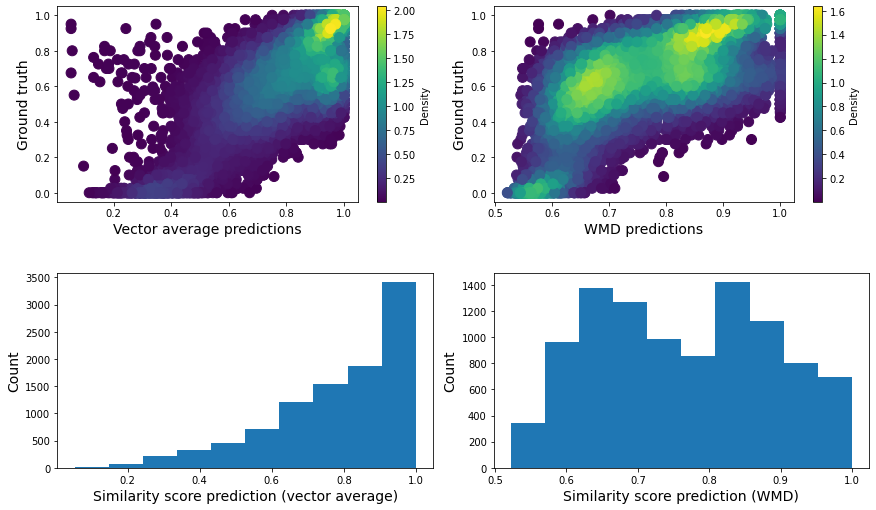

In [ ]:
fig, ax = plt.subplots(2, 2, sharey = False, sharex = False, figsize=(12,7))
fig.tight_layout(h_pad=5, w_pad = 3)
dens1 = ax[0, 0].scatter(sick.google_sim, sick["sim01"], c=density_plot("google_sim", sick), s=100)
ax[0, 0].set_ylabel('Ground truth', size = 14)
ax[0, 0].set_xlabel("Vector average predictions", size = 14)
fig.colorbar(dens1, ax=ax[0, 0], label = "Density")
dens2 = ax[0, 1].scatter(sick["wmd_google"], sick["sim01"], c=density_plot("wmd_google", sick), s=100)
ax[0, 1].set_ylabel('Ground truth', size = 14)
ax[0, 1].set_xlabel("WMD predictions", size = 14)
bar2 = fig.colorbar(dens2, ax=ax[0, 1])
bar2.set_label("Density")
ax[1, 0].hist(sick.google_sim)
ax[1, 0].set_ylabel('Count', size = 14)
ax[1, 0].set_xlabel("Similarity score prediction (vector average)", size = 14)
ax[1, 1].hist(sick.wmd_google)
ax[1, 1].set_ylabel('Count', size = 14)
ax[1, 1].set_xlabel("Similarity score prediction (WMD)", size = 14)
# plt.savefig("distort.pdf", bbox_inches='tight')

## Isotonic regression

In [ ]:
def iso(dt_train, dt_test, col_in):
  iso = IsotonicRegression(out_of_bounds="clip").fit(dt_train[col_in], dt_train["sim01"])
  return(iso.predict(dt_test[col_in]))

def add_iso(dt_train, dt_bert_train, dt_test, dt_bert_test):
  # WMD isotonic regression
  dt_bert_test.loc[:, ("iso_bert")] = iso(dt_bert_train, dt_bert_test, "wmd_bert")
  dt_test.loc[:, ("iso_google")] = iso(dt_train, dt_test, "wmd_google")
  dt_test.loc[:, ("iso_glove")] = iso(dt_train, dt_test, "wmd_glove")

  # Vector average isotonic regression
  dt_bert_test.loc[:, ("iso_bert_aver")] = iso(dt_bert_train, dt_bert_test, "bert_sim")
  dt_test.loc[:, ("iso_google_aver")] = iso(dt_train, dt_test, "google_sim")
  dt_test.loc[:, ("iso_glove_aver")] = iso(dt_train, dt_test, "glove_sim")

add_iso(sick_train, sick_bert_train, sick_test, sick_bert_test)
add_iso(sts_train, sts_bert_train, sts_test, sts_bert_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

## Calibrated SICK

In [ ]:
print("Correlation for calibrated average Bert on SICK:", 
      stat.pearsonr(sick_bert_test["iso_bert_aver"], sick_bert_test["sim"])[0])
print("Correlation for calibrated average Word2vec on SICK:", 
      stat.pearsonr(sick_test["iso_google_aver"], sick_test["sim"])[0])
print("Correlation for calibrated average Glove on SICK:", 
      stat.pearsonr(sick_test["iso_glove_aver"], sick_test["sim"])[0])
print("Correlation for calibrated wmd Bert on SICK:", stat.pearsonr(sick_bert_test["iso_bert"], 
                                                                sick_bert_test["sim"])[0])
print("Correlation for calibrated wmd Word2vec on SICK:", stat.pearsonr(sick_test["iso_google"], 
                                                                    sick_test["sim"])[0])
print("Correlation for calibrated wmd Glove on SICK:", stat.pearsonr(sick_test["iso_glove"],
                                                                 sick_test["sim"])[0])


Correlation for calibrated wmd Bert on SICK: 0.5293489996161992
Correlation for calibrated wmd Word2vec on SICK: 0.7077476218029456
Correlation for calibrated wmd Glove on SICK: 0.6749192820495525
Correlation for calibrated average Bert on SICK: 0.5044571124807715
Correlation for calibrated average Word2vec on SICK: 0.7246283697292187
Correlation for calibrated average Glove on SICK: 0.6571813841289792


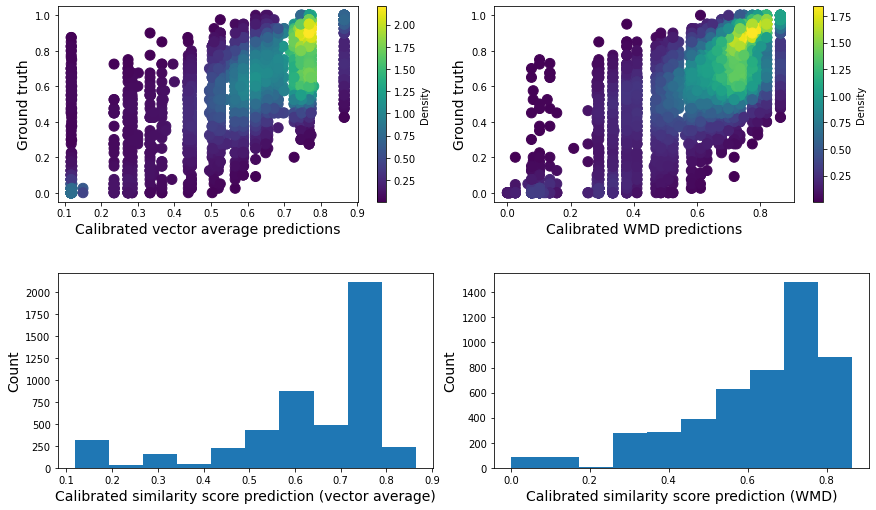

In [ ]:
fig, ax = plt.subplots(2, 2, sharey = False, sharex = False, figsize=(12,7))
fig.tight_layout(h_pad=5, w_pad = 3)
dens1 = ax[0, 0].scatter(sick_test["iso_google_aver"], sick_test["sim01"], 
                         c=density_plot("iso_google_aver", sick_test), s=100)
ax[0, 0].set_ylabel('Ground truth', size = 14)
ax[0, 0].set_xlabel("Calibrated vector average predictions", size = 14)
fig.colorbar(dens1, ax=ax[0, 0], label = "Density")
dens2 = ax[0, 1].scatter(sick_test["iso_google"], sick_test["sim01"], 
                         c=density_plot("iso_google", sick_test), s=100)
ax[0, 1].set_ylabel('Ground truth', size = 14)
ax[0, 1].set_xlabel("Calibrated WMD predictions", size = 14)
bar2 = fig.colorbar(dens2, ax=ax[0, 1])
bar2.set_label("Density")
ax[1, 0].hist(sick_test.iso_google_aver)
ax[1, 0].set_ylabel('Count', size = 14)
ax[1, 0].set_xlabel("Calibrated similarity score prediction (vector average)", size = 14)
ax[1, 1].hist(sick_test.iso_google)
ax[1, 1].set_ylabel('Count', size = 14)
ax[1, 1].set_xlabel("Calibrated similarity score prediction (WMD)", size = 14)
# plt.savefig("iso_results.pdf", bbox_inches='tight')

## Calibrated STS 

In [ ]:
print("Correlation for calibrated average Bert for STS:", 
      stat.pearsonr(sts_bert_test["iso_bert_aver"], sts_bert_test["sim"])[0])
print("Correlation for calibrated average Word2vec for STS:", 
      stat.pearsonr(sts_test["iso_google_aver"], sts_test["sim"])[0])
print("Correlation for calibrated average Glove for STS:", 
      stat.pearsonr(sts_test["iso_glove_aver"], sts_test["sim"])[0])
print("Correlation for calibrated wmd Bert for STS:", stat.pearsonr(sts_bert_test["iso_bert"], 
                                                            sts_bert_test["sim"])[0])
print("Correlation for calibrated wmd Word2vec for STS:", stat.pearsonr(sts_test["iso_google"], 
                                                                    sts_test["sim"])[0])
print("Correlation for calibrated wmd Glove for STS:", stat.pearsonr(sts_test["iso_glove"],
                                                                 sts_test["sim"])[0])

Correlation for calibrated wmd Bert for STS: 0.4269808031623498
Correlation for calibrated wmd Word2vec for STS: 0.6948130027601424
Correlation for calibrated wmd Glove for STS: 0.6225142440790241
Correlation for calibrated average Bert for STS: 0.44678710867983895
Correlation for calibrated average Word2vec for STS: 0.6169002135073417
Correlation for calibrated average Glove for STS: 0.5935715881913393


# Most erroneous sentences

In [ ]:
# Scaling the predictions
def scale_function(var):
    return((var - min(var))/(max(var) - min(var)))
sick_test.loc[:, ("sim_scaled")] = scale_function(sick_test.google_sim)
sick_test.loc[:, ("diff")] = abs(sick_test.sim_scaled - sick_test.sim01)
sts_test.loc[:, ("sim_scaled")] = scale_function(sts_test.wmd_google)
sts_test.loc[:, ("diff")] = abs(sts_test.sim_scaled - sts_test.sim01)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
# Make the whole length of sentences visible
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print top 5 worst predictions
def print_worst(sim_var, diff_var, dt):
    dt.loc[:, ("index")] = dt.index
    worst = dt.sort_values(by=[diff_var], ascending = False)["index"]
    display(dt.iloc[worst[0:5]][["sent1", "sent2", "sent_punct1", "sent_punct2", sim_var, "sim01"]])

In [ ]:
sick_test = sick_test.reset_index(drop=True)
print_worst("sim_scaled", "diff", sick_test)

,sent1,sent2,sent_punct1,sent_punct2,sim_scaled,sim01
1988,The person is riding a jetski in the waves,A woman is riding a Seadoo,person riding jetski waves,woman riding seadoo,0.032294,0.825
1989,A person is riding a jetski in the waves,A woman is riding a Seadoo,person riding jetski waves,woman riding seadoo,0.032294,0.800
3843,Three people are driving ATVs,Three people are driving four wheel vehicles in a field,three people driving atvs,three people driving four wheel vehicles field,0.114332,0.800
1223,A baby rhino is walking around a pen with its mother,A mother is giving the baby a pen with a walking rhino on it,baby rhino walking around pen mother,mother giving baby pen walking rhino,0.954012,0.275
808,A man is typing on a machine used for stenography,The man isn't operating a stenograph,man typing machine used stenography,man operating stenograph,0.000000,0.675


Jetski, seadoo present? avt present?

In [ ]:
sts_test = sts_test.reset_index(drop=True)
print_worst("sim_scaled", "diff", sts_test)

,sent1,sent2,sent_punct1,sent_punct2,sim_scaled,sim01
870,You may have to experiment and find what you like.,You have to find out what works for you.,may experiment find like,find works you,0.286771,1.00
862,I realized there is already an accepted answer but I figure I would add my 2 cents.,I know this is an old question but I feel I should add my 2 cents.,realized already accepted answer figure would add 2 cents,know old question feel add 2 cents,0.328770,1.00
845,It's pretty much up to you.,It is up to you.,pretty much you,you,0.346260,1.00
814,I have the same thing.,I have the exact same problem.,thing,exact problem,0.151690,0.80
1322,Croatia begins countdown to historic EU entry,Croatia countdowns to joining EU,croatia begins countdown historic eu entry,croatia countdowns joining eu,0.314975,0.96


## Closest words to "experiment"

In [ ]:
# Vectors for words of interest
experiment = google_news_vectors["experiment"]
science = google_news_vectors["science"]
find = google_news_vectors["find"]
work = google_news_vectors["work"]
procedure = google_news_vectors["procedure"]
study = google_news_vectors["study"]
test = google_news_vectors["test"]
prototype = google_news_vectors["prototype"]
randomise = google_news_vectors["randomise"]

In [ ]:
# Combining all words into a list
all_wrds = [experiment, science, find, work, procedure, study, test, prototype, randomise]
vecs_example = np.zeros((len(all_wrds), 300))
for nb, wrd in enumerate(all_wrds):
    vecs_example[nb] = wrd
# PCA
pca = PCA(n_components=2)
pca_example = pca.fit_transform(vecs_example)
# Normalising
normalized = normalize(pca_example, norm='l2')
# Adding some noise for plotting purposes
normalized = normalized + np.random.normal(loc=0, scale = 0.15, size= pca_example.shape)

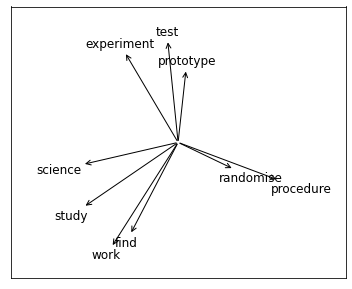

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.set_ylim([-1.3,1.3])
ax.set_xlim([-1.3,1.3])
for nb, wrd in enumerate(["experiment", "science", "find", "work", "procedure", "study", "test",
                          "prototype", "randomise"]):
    ax.annotate(s = wrd, xy=(0, 0) , xytext=(normalized[nb][0], normalized[nb][1]), 
                arrowprops=dict(arrowstyle="<-"), ha='right', va='center', size = 12)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
# fig.savefig('experiment.pdf', bbox_inches='tight') 

In [ ]:
google_news_vectors.most_similar(["experiment"], topn = 100)

[('experiments', 0.7225676774978638),
 ('Experiment', 0.5934476852416992),
 ('experimentation', 0.563130259513855),
 ('experiement', 0.5486840605735779),
 ('Experiments', 0.5407910346984863),
 ('experimental', 0.5351316928863525),
 ('experimenting', 0.5166691541671753),
 ('experimenters', 0.5019431114196777),
 ('experimented', 0.489100843667984),
 ('laboratory_experiments', 0.4864266514778137),
 ('experimentations', 0.46196818351745605),
 ('experimentally', 0.4419797658920288),
 ('study', 0.44044411182403564),
 ('Biofuel_Blast', 0.42870762944221497),
 ('Joint_Expeditionary_Force', 0.4244947135448456),
 ('petri_dish', 0.41965997219085693),
 ('supercomputer_simulations', 0.41674667596817017),
 ('Benthic_Rover', 0.41673120856285095),
 ('Milgram_experiment', 0.41433343291282654),
 ('frog_dissection', 0.4136706292629242),
 ('concept', 0.4126122295856476),
 ('Petri_dish', 0.40942031145095825),
 ('test', 0.40884193778038025),
 ('Experimenting', 0.40857747197151184),
 ('Dr_Ehrsson', 0.40844660